# Estimate generation v2

Use advanced models for generation estimation in the Global Power Plant Database.
Primary model is a two-hidden-layer neural network.

In [50]:
# import what we'll need and set parameters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Dropout, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pydot

GPPD_FILENAME = '../../output_database/global_power_plant_database.csv'
WEIGHTS_FILE = "model/estimate_generation.h5"
VALIDATION_FRACTION = 0.2


In [37]:
# set up fuel colors

fuel_color = { 'Biomass':'#33a02c',
                'Coal':'sienna',
                'Cogeneration':'#e31a1c',
                'Gas':'#a6cee3',
                'Geothermal':'#b2df8a',
                'Hydro':'#1f78b4',
                'Nuclear':'#6a3d9a',
                'Oil':'black',
                'Other':'gray',
                'Petcoke':'#fb9a99',
                'Solar':'#ffff99',
                'Storage':'#ff1010',   # need better color
                'Waste':'#fdbf6f',
                'Wave_and_Tidal':'#b15928',
                'Wind':'#ff7f00'
}


In [2]:
# read in database
df = pd.read_csv(GPPD_FILENAME)
df.head()


country country_long                                               name  \
0     AFG  Afghanistan       Kajaki Hydroelectric Power Plant Afghanistan   
1     AFG  Afghanistan      Mahipar Hydroelectric Power Plant Afghanistan   
2     AFG  Afghanistan   Naghlu Dam Hydroelectric Power Plant Afghanistan   
3     AFG  Afghanistan  Nangarhar (Darunta) Hydroelectric Power Plant ...   
4     AFG  Afghanistan            Northwest Kabul Power Plant Afghanistan   

      gppd_idnr  capacity_mw  latitude  longitude  fuel1 fuel2 fuel3  \
0  GEODB0040538        33.00   32.3220    65.1190  Hydro   NaN   NaN   
1  GEODB0040541        66.00   34.5560    69.4787  Hydro   NaN   NaN   
2  GEODB0040534       100.00   34.6410    69.7170  Hydro   NaN   NaN   
3  GEODB0040536        11.55   34.4847    70.3633  Hydro   NaN   NaN   
4  GEODB0040540        42.00   34.5638    69.1134    Gas   NaN   NaN   

             ...            owner  source                                 url  \
0            ...              NaN   GEODB  http://globalenergyobservatory.org   
1            ...              NaN   GEODB  http://globalenergyobservatory.org   
2            ...              NaN   GEODB  http://globalenergyobservatory.org   
3            ...              NaN   GEODB  http://globalenergyobservatory.org   
4            ...              NaN   GEODB  http://globalenergyobservatory.org   

  geolocation_source year_of_capacity_data generation_gwh_2013  \
0              GEODB                2017.0                 NaN   
1              GEODB                2017.0                 NaN   
2              GEODB                2017.0                 NaN   
3              GEODB                2017.0                 NaN   
4              GEODB                2017.0                 NaN   

   generation_gwh_2014  generation_gwh_2015  generation_gwh_2016  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

   estimated_generation_gwh  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 22 columns]

In [3]:
# show count for number of valid entries in each column
df.count()

country                     25657
country_long                25657
name                        25637
gppd_idnr                   25657
capacity_mw                 25657
latitude                    25657
longitude                   25657
fuel1                       25657
fuel2                        1670
fuel3                         295
fuel4                         107
commissioning_year          13933
owner                       17157
source                      25657
url                         25657
geolocation_source          25657
year_of_capacity_data       16065
generation_gwh_2013           371
generation_gwh_2014           386
generation_gwh_2015           887
generation_gwh_2016          8326
estimated_generation_gwh    24633
dtype: int64

In [4]:
# prepare data for training

# convert string-type columns to categories (assume no NaNs in these columns)
factorized_countries,country_key = df['country'].factorize()
df['country'] = factorized_countries
factorized_fuel1,fuel1_key = df['fuel1'].factorize()
df['fuel1'] = factorized_fuel1

# create new data frame with relevant predictor variable (X) columns and 2016 generation
# clean data frame by removing NaNs
X_columns = ['country','capacity_mw','latitude','longitude','commissioning_year','fuel1']
df_clean = df[X_columns + ['generation_gwh_2016']].dropna(how='any')

# convert 2016 generation into capacity factor and remove rows with erroneous capacity factors
df_clean['capacity_factor'] = df_clean.apply(lambda row:row['generation_gwh_2016']/(24.0*365.0*0.001*row['capacity_mw']),axis=1)
df_clean = df_clean[df_clean.capacity_factor >= 0.0]
df_clean = df_clean[df_clean.capacity_factor <= 1.0]

# create np arrays from data frame
X_data = df_clean[X_columns].as_matrix()
y_column = ['capacity_factor']
y_data = df_clean[y_column].as_matrix()

# show results
print(X_data)
print(y_data)
print(len(X_data))
print(len(y_data))

[[  8.00000000e+00   2.89000000e+02   4.72078000e+01   1.10057000e+01
    1.98100000e+03   0.00000000e+00]
 [  8.00000000e+00   5.00000000e+02   4.72696000e+01   1.09678000e+01
    1.98100000e+03   0.00000000e+00]
 [  4.30000000e+01   2.25000000e+03   3.02483000e+01   3.09471000e+01
    2.01400000e+03   1.00000000e+00]
 ..., 
 [  1.57000000e+02   2.80000000e+01   1.43611000e+01   1.08720300e+02
    2.01400000e+03   0.00000000e+00]
 [  1.57000000e+02   1.95000000e+01   1.21526000e+01   1.08378700e+02
    2.01000000e+03   0.00000000e+00]
 [  1.57000000e+02   3.00000000e+01   1.58600000e+01   1.07653800e+02
    2.00900000e+03   0.00000000e+00]]
[[ 0.04692255]
 [ 0.02934475]
 [ 0.00674784]
 ..., 
 [ 0.41992825]
 [ 0.46247512]
 [ 0.46689498]]
8055
8055


Y data max: 0.998536954444, min: 0.0


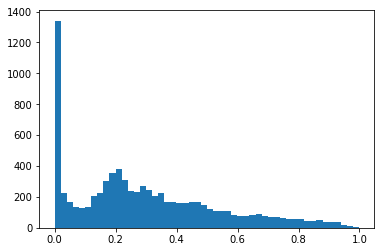

In [5]:
# examine training data to confirm valid capacity factors

print(u"Y data max: {0}, min: {1}".format(y_data.max(),y_data.min()))
plt.hist(y_data,bins=50)
plt.show()

In [6]:
# calculate scaling values for input data

mean_vals = np.mean(X_data,axis=0)
range_vals = np.max(X_data,axis=0) - np.min(X_data,axis=0)

In [41]:
# set up neural network

INPUT_SHAPE = X_data[0].shape
print(u"Input shape is: {0}".format(INPUT_SHAPE))
DROPOUT_RATE = 0.15
DENSE_LAYER_SIZE = 128

def myNet():
    model = Sequential()
    model.add(Lambda(lambda x: x - mean_vals,input_shape = INPUT_SHAPE))   # placeholder for normalization
    model.add(Dense(DENSE_LAYER_SIZE,activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(DENSE_LAYER_SIZE,activation='relu'))
    model.add(Dense(1))
    return model
    
model = myNet()
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Model contains {0} parameters.".format(model.count_params()))
print(model.summary())

Input shape is: (6,)
Model contains 34049 parameters.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)       

In [46]:
# fit model

BATCH_SIZE = 64
NUM_EPOCHS = 512
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=64)
check_point = ModelCheckpoint(WEIGHTS_FILE,monitor='val_loss',save_best_only=True,mode='max')
history_object = model.fit(x=X_data, y=y_data,
                           batch_size = BATCH_SIZE,
                           epochs = NUM_EPOCHS,
                           verbose = 1,
                           callbacks = [early_stop,check_point],
                           validation_split = VALIDATION_FRACTION)
                           
# reload model with best weights from training
model = myNet()
model.load_weights(WEIGHTS_FILE)
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])
print("Finished training; model reloaded with optimum weights.")
#model.save(WEIGHTS_FILE)

Train on 6444 samples, validate on 1611 samples
Epoch 1/512
6444/6444 [==============================] - 1s 79us/step - loss: 0.0365 - mean_absolute_error: 0.1393 - val_loss: 0.0739 - val_mean_absolute_error: 0.1800
Epoch 2/512
6444/6444 [==============================] - 0s 76us/step - loss: 0.0352 - mean_absolute_error: 0.1374 - val_loss: 0.0419 - val_mean_absolute_error: 0.1469
Epoch 3/512
6444/6444 [==============================] - 0s 73us/step - loss: 0.0355 - mean_absolute_error: 0.1381 - val_loss: 0.0556 - val_mean_absolute_error: 0.1665
Epoch 4/512
6444/6444 [==============================] - 0s 75us/step - loss: 0.0356 - mean_absolute_error: 0.1381 - val_loss: 0.0494 - val_mean_absolute_error: 0.1576
Epoch 5/512
6444/6444 [==============================] - 0s 75us/step - loss: 0.0351 - mean_absolute_error: 0.1363 - val_loss: 0.0731 - val_mean_absolute_error: 0.1799
Epoch 6/512
6444/6444 [==============================] - 0s 74us/step - loss: 0.0357 - mean_absolute_error: 0.13

6444/6444 [==============================] - 1s 78us/step - loss: 0.0355 - mean_absolute_error: 0.1370 - val_loss: 0.0361 - val_mean_absolute_error: 0.1332
Epoch 50/512
6444/6444 [==============================] - 1s 81us/step - loss: 0.0344 - mean_absolute_error: 0.1348 - val_loss: 0.0399 - val_mean_absolute_error: 0.1446
Epoch 51/512
6444/6444 [==============================] - 0s 75us/step - loss: 0.0348 - mean_absolute_error: 0.1359 - val_loss: 0.0657 - val_mean_absolute_error: 0.1735
Epoch 52/512
6444/6444 [==============================] - 0s 71us/step - loss: 0.0343 - mean_absolute_error: 0.1347 - val_loss: 0.0343 - val_mean_absolute_error: 0.1263
Epoch 53/512
6444/6444 [==============================] - 0s 73us/step - loss: 0.0341 - mean_absolute_error: 0.1342 - val_loss: 0.0345 - val_mean_absolute_error: 0.1259
Epoch 54/512
6444/6444 [==============================] - 1s 90us/step - loss: 0.0360 - mean_absolute_error: 0.1374 - val_loss: 0.0778 - val_mean_absolute_error: 0.1810

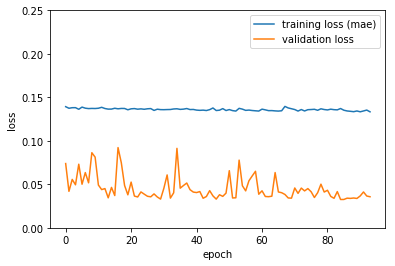

In [47]:
# plot training loss history
    
plt.plot(history_object.history['mean_absolute_error'])
plt.plot(history_object.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss (mae)','validation loss'],loc='upper right')
plt.ylim([0,0.25])
plt.show()

In [12]:
# visualize model

#SVG(model_to_dot(model).create(prog='dot',format='svg'))

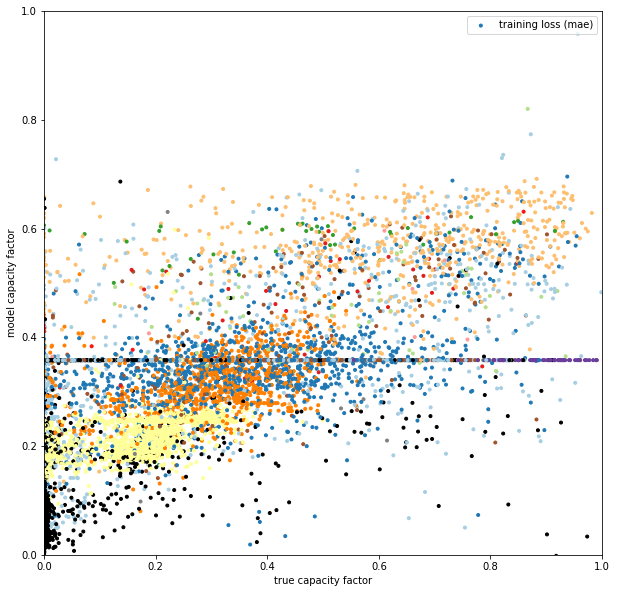

In [49]:
# apply model

prediction_values = model.predict(X_data)
fig = plt.figure(figsize=(10,10))
colors = [fuel_color[fuel1_key[int(c)]] for c in X_data[:,5]]
plt.scatter(y_data,prediction_values,marker='.',c=colors)
plt.xlabel('true capacity factor')
plt.ylabel('model capacity factor')
plt.legend(['training loss (mae)','validation loss'],loc='upper right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [51]:
# calculate simple r2 for training data, model value

r2_score = metrics.r2_score(y_data,prediction_values)
print(u"R2 score: {0}".format(r2_score))


R2 score: 0.222965090425
